In [0]:
# Start Python Imports
import math, time, random, datetime
 
# Importing basic libraries
import numpy as np 
import pandas as pd 
 
# Input data files are downloaded and are available at my local disk
import os
from PIL import  Image
%matplotlib inline
import itertools
import warnings
warnings.filterwarnings("ignore")
 
# Preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold 
from sklearn import model_selection, metrics
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

# Importing classifiers
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from mlxtend.classifier import EnsembleVoteClassifier
 
# Imports for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
 
# Evaluation
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer, f1_score, auc, precision_score, recall_score
import statsmodels.api as sm
from yellowbrick.classifier import DiscriminationThreshold
from sklearn.metrics import precision_recall_fscore_support

1. Data

In [0]:
# Import train data
from google.colab import files
uploaded = files.upload() 
import io
train = pd.read_csv(io.BytesIO(uploaded['train.csv']))

Saving train.csv to train (2).csv


In [0]:
# Import test data
from google.colab import files
uploaded = files.upload() 
import io
test = pd.read_csv(io.BytesIO(uploaded['test.csv']))

Saving test.csv to test (2).csv


In [0]:
# Import sample submission (how submission should look like?)
from google.colab import files
uploaded = files.upload() 
import io
sampleSubmission = pd.read_csv(io.BytesIO(uploaded['sampleSubmission.csv']))

Saving sampleSubmission.csv to sampleSubmission (2).csv


2. Data Overview

In [0]:
# View the training data
train.head()

state  account_length  ... number_customer_service_calls churn
0    OH             107  ...                             1    no
1    NJ             137  ...                             0    no
2    OH              84  ...                             2    no
3    OK              75  ...                             3    no
4    MA             121  ...                             3    no

[5 rows x 20 columns]

In [0]:
# View the testing data
test.head()

id state  ...  total_intl_charge number_customer_service_calls
0   1    KS  ...               2.70                             1
1   2    AL  ...               1.70                             0
2   3    IA  ...               3.54                             4
3   4    VT  ...               2.19                             3
4   5    NE  ...               4.19                             3

[5 rows x 20 columns]

In [0]:
# View the example submisison dataframe
sampleSubmission.head()

id churn
0   1   yes
1   2    no
2   3    no
3   4   yes
4   5   yes

In [0]:
train.describe()

account_length  ...  number_customer_service_calls
count     4250.000000  ...                    4250.000000
mean       100.236235  ...                       1.559059
std         39.698401  ...                       1.311434
min          1.000000  ...                       0.000000
25%         73.000000  ...                       1.000000
50%        100.000000  ...                       1.000000
75%        127.000000  ...                       2.000000
max        243.000000  ...                       9.000000

[8 rows x 15 columns]

In [0]:
print("Shape of the dataset: ", train.shape)
print ("\nMissing values : ", train.isnull().sum().values.sum())
print ("\nUnique values : \n", train.nunique())

Shape of the dataset:  (4250, 20)

Missing values :  0

Unique values : 
 state                              51
account_length                    215
area_code                           3
international_plan                  2
voice_mail_plan                     2
number_vmail_messages              46
total_day_minutes                1843
total_day_calls                   120
total_day_charge                 1843
total_eve_minutes                1773
total_eve_calls                   123
total_eve_charge                 1572
total_night_minutes              1757
total_night_calls                 128
total_night_charge                992
total_intl_minutes                168
total_intl_calls                   21
total_intl_charge                 168
number_customer_service_calls      10
churn                               2
dtype: int64


In [0]:
#Separating churn and non churn customers
churn     = train[train["churn"] == "yes"]
not_churn = train[train["churn"] == "no"]

In [0]:
#Separating catagorical and numerical columns
numerical_vars  = ['account_length', 'number_vmail_messages', 'total_day_minutes', 
                   'total_day_calls', 'total_day_charge', 'total_eve_minutes', 
                   'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
                   'total_night_calls',	'total_night_charge', 'total_intl_minutes',
                   'total_intl_calls', 'total_intl_charge',	'number_customer_service_calls']
categorical_vars = ['international_plan', 'voice_mail_plan', 'state', 'area_code']
train = train[['churn'] + numerical_vars + categorical_vars]
test = test[['id'] + numerical_vars + categorical_vars]

3. Exploratory Data Analysis

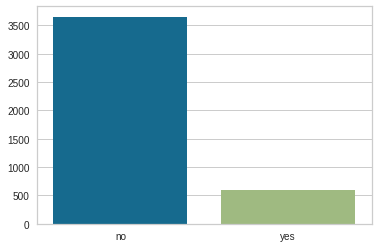

In [0]:
# Target Feature: churn
# Key: 0 = not_churn, 1 = churned

# BarPlot for churn
y = train["churn"].value_counts()
sns.barplot(y.index, y.values)

In [0]:
# Checking for imbalance
y_True = train["churn"][train["churn"] == 'yes']
print ("Churn Percentage = "+str( (y_True.shape[0] / train["churn"].shape[0]) * 100 ))

Churn Percentage = 14.070588235294117


In [0]:
# In order to visualize graphs in colab with plotly, we should use the following function(custom initialization)
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [0]:
def plot_pie(column) :
    
    trace1 = go.Pie(values  = churn[column].value_counts().values.tolist(),
                    labels  = churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "Churn Customers",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    hole    = .6
                   )
    trace2 = go.Pie(values  = not_churn[column].value_counts().values.tolist(),
                    labels  = not_churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "Non churn customers" 
                   )


    layout = go.Layout(dict(title = column + " donat chart for customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .15, y = .5),
                                           dict(text = "Non churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .88,y = .5
                                               )
                                          ]
                           )
                      )
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)


In [0]:
# Visualizing catagorical features regarding the churn value
configure_plotly_browser_state()
plot_pie("international_plan")
plot_pie("area_code")
plot_pie("voice_mail_plan")

In [0]:
#function  for histogram for customer attrition types
def histogram(column) :
    trace1 = go.Histogram(x  = churn[column],
                          histnorm= "percent",
                          name = "Churn customers",
                          marker = dict(line = dict(width = .5,
                                                    color = "black"
                                                    )
                                        ),
                         opacity = .9 
                         ) 
    
    trace2 = go.Histogram(x  = not_churn[column],
                          histnorm = "percent",
                          name = "Non-churn customers",
                          marker = dict(line = dict(width = .5,
                                              color = "black"
                                             )
                                 ),
                          opacity = .9
                         )
    
    data = [trace1,trace2]
    layout = go.Layout(dict(title =column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = column,
                                             zerolinewidth=1,
                                             ticklen=5,
                                         gridwidth=2
                                            ),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "percent",
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                           )
                      )
    fig  = go.Figure(data=data,layout=layout)
    
    py.iplot(fig)

In [0]:
# Visualizing numerical features regarding the churn value
configure_plotly_browser_state()
for features in numerical_vars:
  histogram(features)

4. Data preprocessing

In [0]:
# Creating a new dataframe, one to host discretised continuous variables and continuous variables

df_train = pd.DataFrame() # discretised continuous variables

# Pass the values from train to the df_train 
df_train = train

In [0]:
# 0 and 1 for binary attributes

# Binarize churn 
df_train['churn'] = train['churn']
df_train['churn'] = np.where(df_train['churn'] == 'yes', 1, 0) # change churn to 0 for no and 1 for yes

# Binarize international_plan
df_train['international_plan'] = train['international_plan']
df_train['international_plan'] = np.where(df_train['international_plan'] == 'yes', 1, 0) 

# Binarize voice_mail_plan
df_train['voice_mail_plan'] = train['voice_mail_plan']
df_train['voice_mail_plan'] = np.where(df_train['voice_mail_plan'] == 'yes', 1, 0) 

In [0]:
# Creating 3 new columns to host the totals of "minutes", "calls" and "charges" 

df_train['total_minutes'] = train.total_day_minutes + train.total_eve_minutes + train.total_night_minutes + train.total_intl_minutes
df_train['total_calls'] = train.total_day_calls + train.total_eve_calls + train.total_night_calls + train.total_intl_calls
df_train['total_charge'] = train.total_day_charge + train.total_eve_charge + train.total_night_charge + train.total_intl_charge

In [0]:
df_train

churn  account_length  ...  total_calls  total_charge
0         0             107  ...          332         59.24
1         0             137  ...          333         62.29
2         0              84  ...          255         66.80
3         0              75  ...          359         52.09
4         0             121  ...          321         78.31
...     ...             ...  ...          ...           ...
4245      0              83  ...          243         65.13
4246      0              73  ...          266         52.88
4247      0              75  ...          338         53.10
4248      0              50  ...          374         75.09
4249      0              86  ...          322         54.18

[4250 rows x 23 columns]

In [0]:
# Using dummies for area_code and state

# One hot encode the area_code column
df_area_code_one_hot = pd.get_dummies(df_train['area_code'], prefix='area_code')

# One hot encode the state column
df_state_one_hot = pd.get_dummies(df_train['state'], prefix='state')

# Combine the one hot encoded columns with df_train                                    
df_train = pd.concat([df_train, df_area_code_one_hot, df_state_one_hot], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
df_train = df_train.drop(['area_code', 'state'], axis=1)

In [0]:
# Printing the df_train
df_train 

churn  account_length  ...  state_WV  state_WY
0         0             107  ...         0         0
1         0             137  ...         0         0
2         0              84  ...         0         0
3         0              75  ...         0         0
4         0             121  ...         0         0
...     ...             ...  ...       ...       ...
4245      0              83  ...         0         0
4246      0              73  ...         1         0
4247      0              75  ...         0         0
4248      0              50  ...         0         0
4249      0              86  ...         0         0

[4250 rows x 75 columns]

In [0]:
# Providing a correlation Matrix for features

import plotly.graph_objects as go
from plotly.offline import init_notebook_mode,iplot
configure_plotly_browser_state()

#correlation
correlation = df_train.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)
#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Magma",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )
layout = go.Layout(dict(title = "Correlation Matrix for variables",
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )
data = [trace]
fig = go.Figure(data=data,layout=layout)
iplot(fig)

* The feature selection is based on the correlation matrix (removing the features with very high correlation), the feature importance provided later, as well as the evualuation metrics of the different classifiers. 

In [0]:
# Viewing the dataframe
df_train # Consists of 4250 rows and 27 columns

churn  account_length  ...  state_WV  state_WY
0         0             107  ...         0         0
1         0             137  ...         0         0
2         0              84  ...         0         0
3         0              75  ...         0         0
4         0             121  ...         0         0
...     ...             ...  ...       ...       ...
4245      0              83  ...         0         0
4246      0              73  ...         1         0
4247      0              75  ...         0         0
4248      0              50  ...         0         0
4249      0              86  ...         0         0

[4250 rows x 75 columns]

In [0]:
# Dropping the undesired columns from the dataframe
df_train = df_train.drop(['total_day_charge', 'total_eve_minutes', 'total_night_charge', 'total_intl_charge', 'account_length'], axis = 1)

In [0]:
# Selecting the dataframe we want to use first for predictions
selected_df = df_train
selected_df

churn  number_vmail_messages  ...  state_WV  state_WY
0         0                     26  ...         0         0
1         0                      0  ...         0         0
2         0                      0  ...         0         0
3         0                      0  ...         0         0
4         0                     24  ...         0         0
...     ...                    ...  ...       ...       ...
4245      0                      0  ...         0         0
4246      0                      0  ...         1         0
4247      0                      0  ...         0         0
4248      0                     40  ...         0         0
4249      0                     34  ...         0         0

[4250 rows x 70 columns]

In [0]:
# Spliting the dataframe into data and labels
X_train = selected_df.drop('churn', axis=1) # data
y_train = selected_df.churn # labels

In [0]:
# Shape of the data and labels
print("X_train shape: ", X_train.shape)
print("\ny_train shape: ", y_train.shape)

X_train shape:  (4250, 69)

y_train shape:  (4250,)


5. Building Machine Learning Models

In [0]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train):

    skfold = StratifiedKFold(n_splits=10)
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation using stratified kfold
    train_pred = model_selection.cross_val_predict(algo, X_train, y_train, cv=skfold, n_jobs = -1)

    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

In [0]:
# XGBClassifier
start_time = time.time()
XGB = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1, gamma=0.01, learning_rate=0.1, max_delta_step=0,max_depth=7,
                    min_child_weight=5, missing=None, n_estimators=20,n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,reg_alpha=0, 
                    reg_lambda=1, scale_pos_weight=1, seed=None, silent=True, subsample=1).fit(X_train, y_train)

train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(XGB, X_train, y_train)

xgb_time = (time.time() - start_time)

print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=xgb_time))

Accuracy: 97.81
Accuracy CV 10-Fold: 97.76
Running Time: 0:00:04.143079


In [0]:
# Random forest classifier
start_time = time.time()
Random_Forest = RandomForestClassifier()

train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(Random_Forest, X_train, y_train)

rft_time = (time.time() - start_time)


print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=rft_time))

Accuracy: 100.0
Accuracy CV 10-Fold: 97.11
Running Time: 0:00:06.460200


In [0]:
# Gradient Boosting Trees
start_time = time.time()
GBC = GradientBoostingClassifier()

train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GBC, X_train, y_train)

gbt_time = (time.time() - start_time)

print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 98.42
Accuracy CV 10-Fold: 97.76
Running Time: 0:00:12.073483


Preparing for applying Catboost

In [0]:
pip install catboost

In [0]:
from catboost import CatBoostClassifier, Pool, cv

In [0]:
# Define the categorical features for the CatBoost model
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([ 0,  2,  3,  6,  8,  9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68])

In [0]:
# Use the CatBoost Pool() function to pool together the training data and categorical feature labels
train_pool = Pool(X_train, y_train, cat_features)

In [0]:
# CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000, custom_loss=['Accuracy'], loss_function='Logloss', silent=True) 
# (eval_metric='Accuracy',use_best_model=True,random_seed=42)

# Fit CatBoost model
catboost_model.fit(train_pool, plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [0]:
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool, cv_params, fold_count=10, plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

In [0]:
# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

The following block of code contains an example of GridSearch

In [0]:
"""
def best_model(model):
    print(model.best_score_)    
    print(model.best_params_)
    print(model.best_estimator_)

param_grid = {'C': [0.1,0.5,1,10,50,100], 'max_iter': [250], 'fit_intercept':[True],'intercept_scaling':[1],'penalty':['l2'], 'tol':[0.00001,0.0001,0.000001]}
log_primal_Grid = GridSearchCV(XGB,param_grid, cv=10, refit=True, verbose=0)
log_primal_Grid.fit(selected_df.loc[:, selected_df.columns != 'churn'],selected_df.churn)
best_model(log_primal_Grid)

param_grid = {'n_estimators':[150,200,250,300], 'max_depth':[15,20,25]}
log_primal_Grid = GridSearchCV(Random_Forest, param_grid, cv=10, refit=True, verbose=0)
log_primal_Grid.fit(selected_df.loc[:, selected_df.columns != 'churn'],selected_df.churn)
best_model(log_primal_Grid) 
"""

Using Ensemble Vote Classifier (Soft Voting)

10-RepeatedStratifiedKFold cross validation:

Accuracy: 0.979 (+/- 0.01) [GradientBoostingClassifier]
Accuracy: 0.974 (+/- 0.01) [Random Forest]
Accuracy: 0.978 (+/- 0.01) [XGBClassifier]
Accuracy: 0.979 (+/- 0.01) [Ensemble]


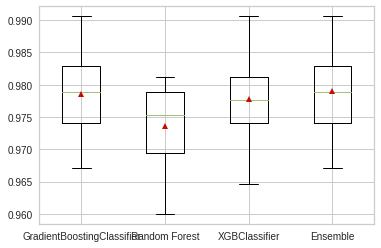

In [136]:
# Implementation of voting EnsembleVoteClassifier for classification with 10 k-fold cross validation   
from sklearn.model_selection import RepeatedStratifiedKFold
clf1 = GradientBoostingClassifier()
clf2 = RandomForestClassifier(random_state=1)
clf3 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1, gamma=0.01, learning_rate=0.1, max_delta_step=0,max_depth=7,
                    min_child_weight=5, missing=None, n_estimators=20,n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,reg_alpha=0, 
                    reg_lambda=1, scale_pos_weight=1, seed=None, silent=True, subsample=1).fit(X_train, y_train)
ensemble = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3], voting='soft')
 
# evaluate a give model using cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
print('10-RepeatedStratifiedKFold cross validation:\n')
 
labels = ['GradientBoostingClassifier', 'Random Forest', 'XGBClassifier','Ensemble']
results = []
for clf, label in zip([clf1, clf2, clf3, ensemble], labels):
 
    scores = model_selection.cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1, error_score='raise')
    results.append(scores)
    print("Accuracy: %0.3f (+/- %0.2f) [%s]"% (scores.mean(), scores.std(), label))
 
plt.boxplot(results, labels=labels, showmeans=True)
plt.show()

6. Evaluation of Clasifiers

6.1 Learning Curves, Precision, Recall, F-measure, Specificity and ROCs for the classifiers 

In [0]:
# Using stratified k-fold 
skfold = StratifiedKFold(n_splits=10)

# Function for plotting several metrics
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    thresh = 0.5

    y_pred = cross_val_predict(estimator, X, y, cv=cv)
    conf_mat = confusion_matrix(y, y_pred)

    #Metrics for evaluation
    aucc = roc_auc_score(y, y_pred)
    recall = recall_score(y, (y_pred > thresh))
    precision = precision_score(y, (y_pred > thresh))
    F1_score = 2 * precision * recall / (precision + recall)
    specificity = sum((y_pred < thresh) & (y == 0)) / sum(y == 0)


    print('Accuracy of %s: %.3f' % (title, max(test_scores_mean)))
    print('Aucc: %.3f' % (aucc))
    print('Recall: %.3f' % (recall))
    print('Precision: %.3f' % (precision))
    print('F1_score: %.3f' % (F1_score))
    print('Specificity: %.3f' % (specificity))

    
    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    fpr, tpr, thresholds = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(' ROC curve graph')
    plt.legend(loc="lower right")
    plt.show()

    return plt

Accuracy of XGBoost learning curves: 0.978
Aucc: 0.921
Recall: 0.843
Precision: 0.998
F1_score: 0.914
Specificity: 1.000


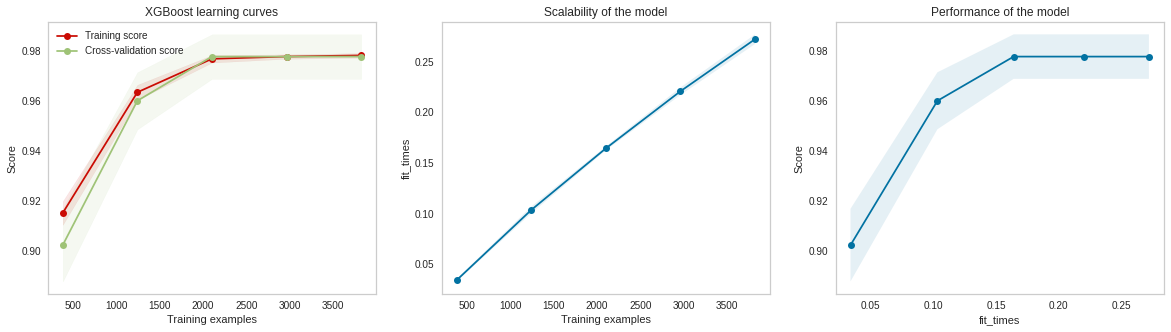

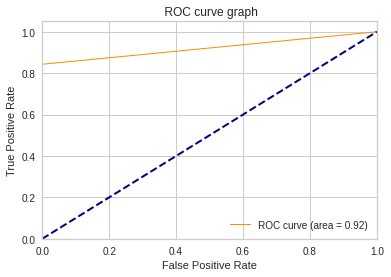

Accuracy of Random Forest learning curves: 0.973
Aucc: 0.913
Recall: 0.826
Precision: 0.998
F1_score: 0.904
Specificity: 1.000


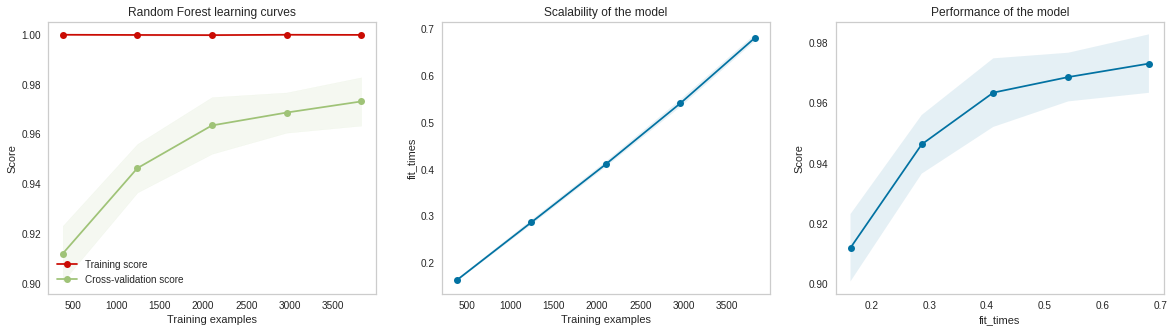

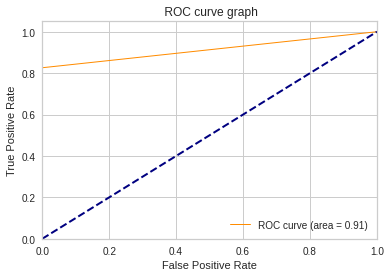

Accuracy of Gradient Boosting Classifier learning curves: 0.979
Aucc: 0.929
Recall: 0.861
Precision: 0.977
F1_score: 0.916
Specificity: 0.997


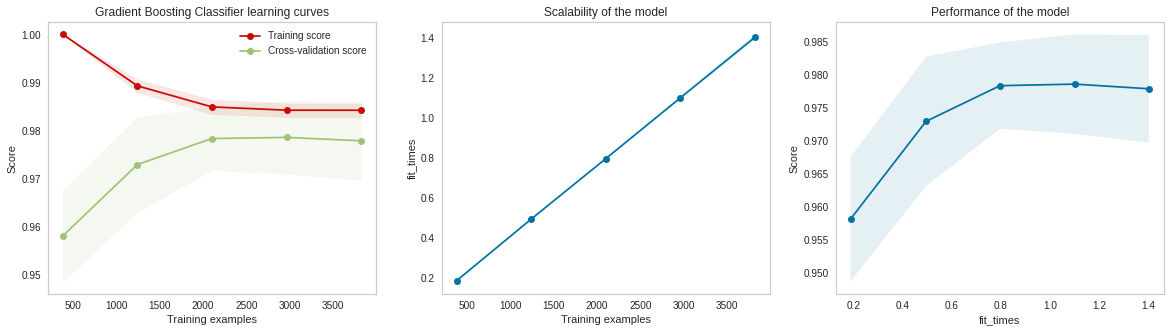

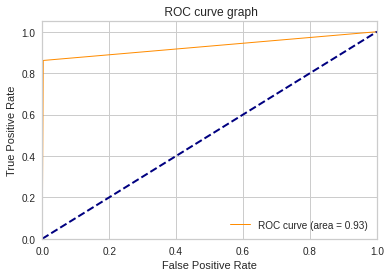

Streaming output truncated to the last 5000 lines.
11:	learn: 0.4577310	total: 56.5ms	remaining: 4.65s
12:	learn: 0.4441520	total: 60.9ms	remaining: 4.62s
13:	learn: 0.4323149	total: 65.3ms	remaining: 4.6s
14:	learn: 0.4193958	total: 69.7ms	remaining: 4.57s
15:	learn: 0.4046162	total: 74ms	remaining: 4.55s
16:	learn: 0.3909587	total: 78.4ms	remaining: 4.53s
17:	learn: 0.3810868	total: 82.8ms	remaining: 4.52s
18:	learn: 0.3685853	total: 88.6ms	remaining: 4.57s
19:	learn: 0.3602822	total: 98.9ms	remaining: 4.85s
20:	learn: 0.3518771	total: 103ms	remaining: 4.82s
21:	learn: 0.3448745	total: 108ms	remaining: 4.79s
22:	learn: 0.3362062	total: 112ms	remaining: 4.76s
23:	learn: 0.3291178	total: 117ms	remaining: 4.74s
24:	learn: 0.3211410	total: 121ms	remaining: 4.73s
25:	learn: 0.3113483	total: 126ms	remaining: 4.71s
26:	learn: 0.3017819	total: 130ms	remaining: 4.69s
27:	learn: 0.2937868	total: 135ms	remaining: 4.67s
28:	learn: 0.2872152	total: 139ms	remaining: 4.66s
29:	learn: 0.2822925	tota

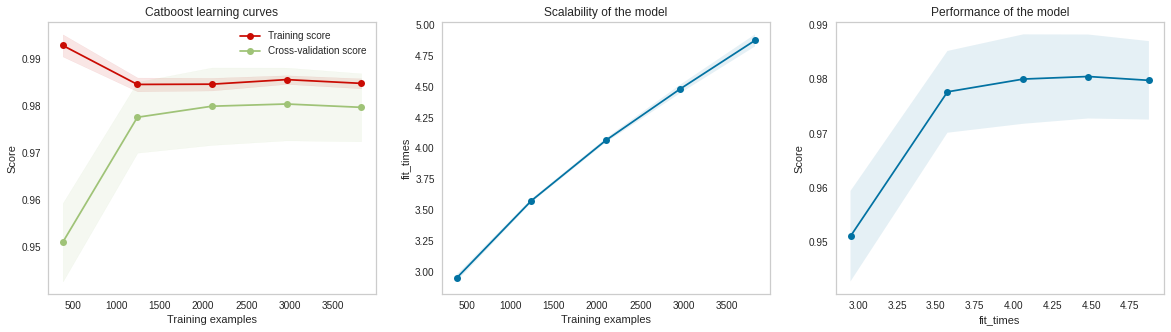

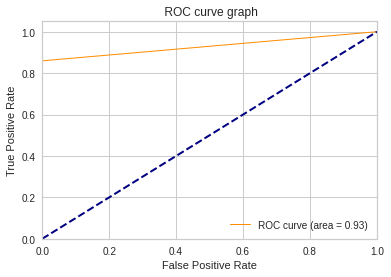

Accuracy of Ensemble learning curves: 0.979
Aucc: 0.926
Recall: 0.853
Precision: 0.998
F1_score: 0.920
Specificity: 1.000


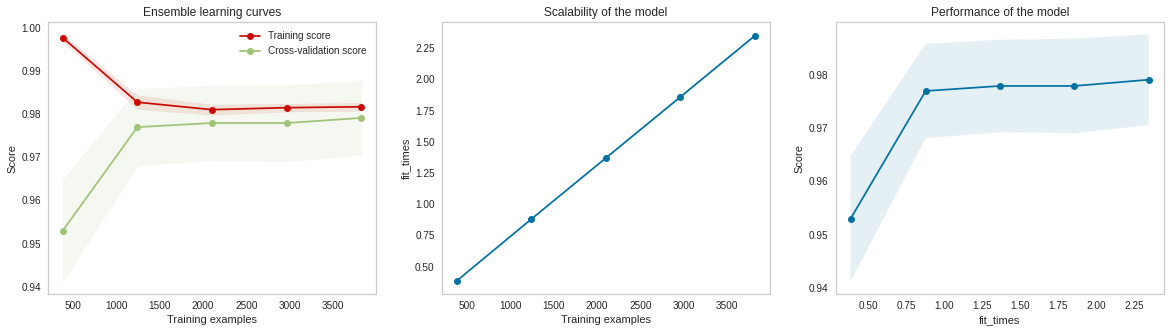

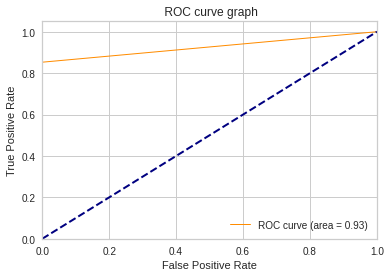

In [0]:
# Calling the learning curves and printing metrics for classifiers
learncurve = plot_learning_curve(XGB, "XGBoost learning curves", X_train, y_train, cv=skfold)
learncurve = plot_learning_curve(Random_Forest, "Random Forest learning curves", X_train, y_train, cv=skfold)
learncurve = plot_learning_curve(GBC, "Gradient Boosting Classifier learning curves", X_train, y_train, cv=skfold)
learncurve = plot_learning_curve(catboost_model, "Catboost learning curves", X_train, y_train, cv=skfold)
learncurve = plot_learning_curve(ensemble, "Ensemble learning curves", X_train, y_train, cv=skfold)

6.2 Confusion Matrix for the classifiers

In [0]:
# Function to compute the y_pred and the confusion matrix

def conf_matrix(classifier, X_train, y_train, cv=10):
  y_pred = cross_val_predict(classifier, X_train, y_train, cv=10)
  conf_mat = confusion_matrix(y_train, y_pred)

  return y_pred, conf_mat


Confusion Matrix for: XGBoost


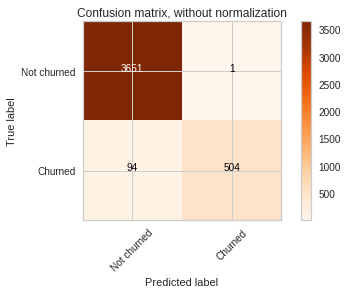

              precision    recall  f1-score   support

 Not churned       0.97      1.00      0.99      3652
     Churned       1.00      0.84      0.91       598

    accuracy                           0.98      4250
   macro avg       0.99      0.92      0.95      4250
weighted avg       0.98      0.98      0.98      4250

Confusion Matrix for: Random_Forest


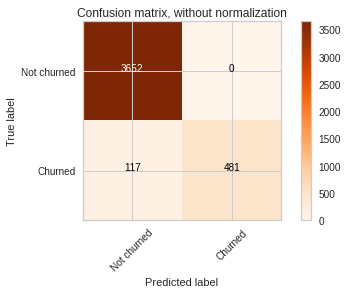

              precision    recall  f1-score   support

 Not churned       0.97      1.00      0.98      3652
     Churned       1.00      0.80      0.89       598

    accuracy                           0.97      4250
   macro avg       0.98      0.90      0.94      4250
weighted avg       0.97      0.97      0.97      4250

Confusion Matrix for: Gradient Boosting


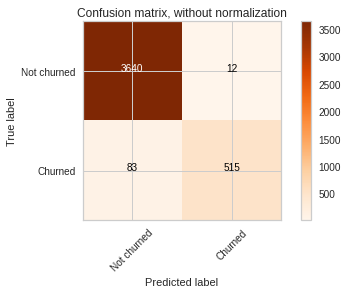

Streaming output truncated to the last 5000 lines.
6:	learn: 0.5396544	total: 36.4ms	remaining: 5.16s
7:	learn: 0.5252599	total: 40.9ms	remaining: 5.07s
8:	learn: 0.5077278	total: 51.3ms	remaining: 5.65s
9:	learn: 0.4895812	total: 56.7ms	remaining: 5.62s
10:	learn: 0.4726234	total: 61.5ms	remaining: 5.53s
11:	learn: 0.4577310	total: 66.2ms	remaining: 5.45s
12:	learn: 0.4441520	total: 71.1ms	remaining: 5.39s
13:	learn: 0.4323149	total: 75.7ms	remaining: 5.33s
14:	learn: 0.4193958	total: 80.4ms	remaining: 5.28s
15:	learn: 0.4046162	total: 85.1ms	remaining: 5.24s
16:	learn: 0.3909587	total: 89.7ms	remaining: 5.19s
17:	learn: 0.3810868	total: 94.3ms	remaining: 5.14s
18:	learn: 0.3685853	total: 99.2ms	remaining: 5.12s
19:	learn: 0.3602822	total: 104ms	remaining: 5.11s
20:	learn: 0.3518771	total: 110ms	remaining: 5.11s
21:	learn: 0.3448745	total: 114ms	remaining: 5.08s
22:	learn: 0.3362062	total: 119ms	remaining: 5.07s
23:	learn: 0.3291178	total: 124ms	remaining: 5.04s
24:	learn: 0.3211410	t

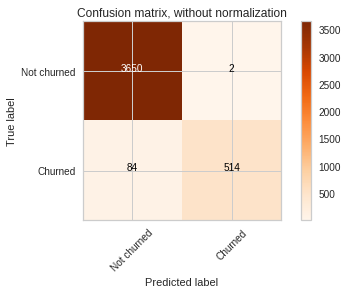

              precision    recall  f1-score   support

 Not churned       0.98      1.00      0.99      3652
     Churned       1.00      0.86      0.92       598

    accuracy                           0.98      4250
   macro avg       0.99      0.93      0.96      4250
weighted avg       0.98      0.98      0.98      4250

Confusion Matrix for: ensemble Model


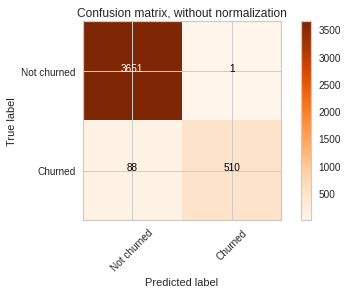

              precision    recall  f1-score   support

 Not churned       0.98      1.00      0.99      3652
     Churned       1.00      0.85      0.92       598

    accuracy                           0.98      4250
   macro avg       0.99      0.93      0.95      4250
weighted avg       0.98      0.98      0.98      4250



In [0]:
# Confusion Matrix with Eval metris

def plot_confusion_matrix(clf, cm, classes, normalize=False, title='Confusion Matrix',cmap=plt.cm.Oranges):
 
    print('Confusion Matrix for:', clf)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

 
# Compute confusion matrixes for XGB
y_pred, XGB_matrix = conf_matrix(XGB, X_train, y_train, cv=10)
np.set_printoptions(precision=2)
 
plt.figure()
class_names = ['Not churned','Churned']
plot_confusion_matrix("XGBoost", XGB_matrix, classes=class_names, title='Confusion matrix, without normalization')
plt.show()
  
eval_metrics = classification_report(y_train, y_pred, target_names=class_names)
print(eval_metrics)
 
# Compute confusion matrixes for Random Forest
y_pred, Random_Forest_matrix = conf_matrix(Random_Forest, X_train, y_train, cv=10)
np.set_printoptions(precision=2)
 
plt.figure()
class_names = ['Not churned','Churned']
plot_confusion_matrix("Random_Forest", Random_Forest_matrix, classes=class_names, title='Confusion matrix, without normalization')
plt.show()
 
eval_metrics = classification_report(y_train, y_pred, target_names=class_names)
print(eval_metrics)
 
# Compute confusion matrixes for Gradient Boosting Classifier
y_pred, GBC_matrix = conf_matrix(GBC, X_train, y_train, cv=10)
np.set_printoptions(precision=2)
 
plt.figure()
class_names = ['Not churned','Churned']
plot_confusion_matrix("Gradient Boosting", GBC_matrix, classes=class_names, title='Confusion matrix, without normalization')
plt.show()
 
eval_metrics = classification_report(y_train, y_pred, target_names=class_names)
print(eval_metrics)
 
# Compute confusion matrixes for Catboost
y_pred, Catboost_matrix = conf_matrix(catboost_model, X_train, y_train, cv=10)
np.set_printoptions(precision=2)

plt.figure()
class_names = ['Not churned','Churned']
plot_confusion_matrix("Catboost Model", Catboost_matrix, classes=class_names, title='Confusion matrix, without normalization')
plt.show()
 
eval_metrics4 = classification_report(y_train, y_pred, target_names=class_names)
print(eval_metrics4)

# Compute confusion matrixes for Ensemble 
y_pred, ensemble_matrix = conf_matrix(ensemble, X_train, y_train, cv=10)
np.set_printoptions(precision=2)

plt.figure()
class_names = ['Not churned','Churned']
plot_confusion_matrix("ensemble Model", ensemble_matrix, classes=class_names, title='Confusion matrix, without normalization')
plt.show()
 
eval_metrics= classification_report(y_train, y_pred, target_names=class_names)
print(eval_metrics)

6.4 Using catboost to obtain feature importance

imp                            col
27  0.000000                       state_FL
26  0.000000                       state_DE
24  0.000000                       state_CT
23  0.000000                       state_CO
22  0.000000                       state_CA
21  0.000000                       state_AZ
20  0.000000                       state_AR
19  0.000000                       state_AL
18  0.000000                       state_AK
17  0.000000        area_code_area_code_510
16  0.000000        area_code_area_code_415
15  0.000000        area_code_area_code_408
13  0.000448                    total_calls
33  0.000667                       state_IN
25  0.000762                       state_DC
1   0.000872              total_day_minutes
43  0.000943                       state_MS
53  0.001089                       state_OH
3   0.001212                total_eve_calls
4   0.001388               total_eve_charge
5   0.001954            total_night_minutes
12  0.003789                  total_minutes
6   0.004681              total_night_calls
2   0.005712                total_day_calls
8   0.070161               total_intl_calls
7   0.100314             total_intl_minutes
10  0.103196             international_plan
0   0.143823          number_vmail_messages
9   0.178108  number_customer_service_calls
14  0.380881                   total_charge

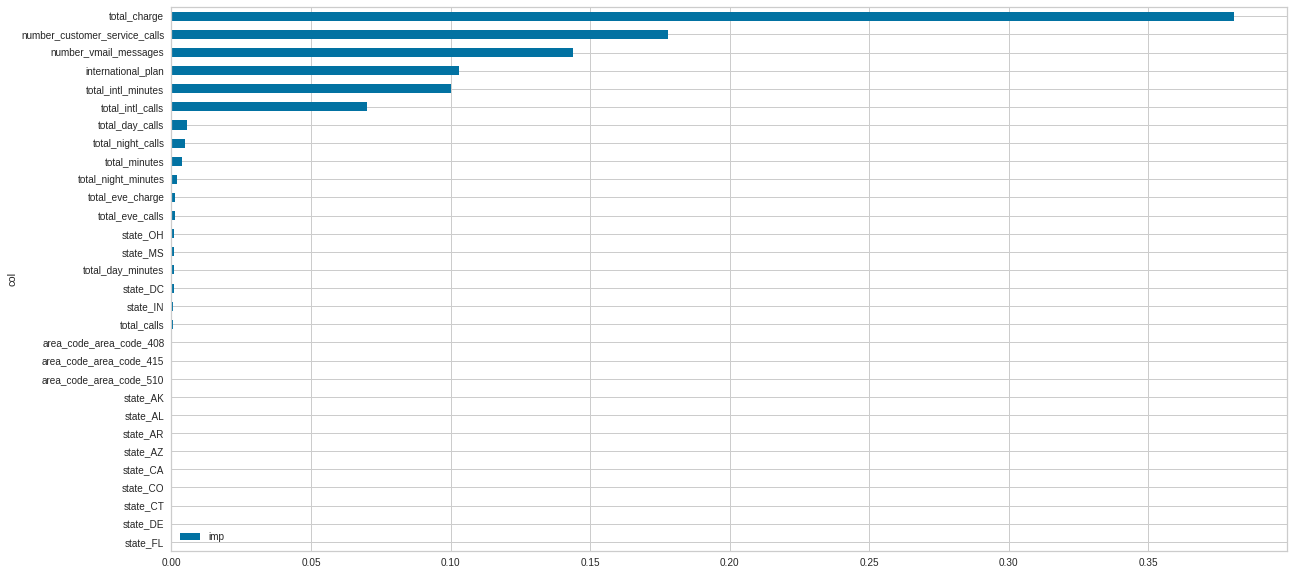

In [0]:
# Feature Importance based on Catboost

def feature_importance(model, data):
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp

feature_importance(XGB, X_train)

7. Obtaining Results

In [0]:
# Binarize international_plan
test['international_plan'] = np.where(test['international_plan'] == 'yes', 1, 0) 

# Binarize voice_mail_plan
test['voice_mail_plan'] = np.where(test['voice_mail_plan'] == 'yes', 1, 0) 

In [0]:
# Applying the same procedure for the test data

# One hot encode the area_code
test_area_code_one_hot = pd.get_dummies(test['area_code'], prefix='area_code')

# Combine the one hot encoded columns with df_con                                    
test = pd.concat([test, test_area_code_one_hot], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
test = test.drop(['area_code'], axis=1) 

# One hot encode the area_code
test_state_one_hot = pd.get_dummies(test['state'], prefix='state')

# Combine the one hot encoded columns with df_con                                    
test = pd.concat([test, test_state_one_hot], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
test = test.drop(['state'], axis=1) 

test['total_minutes'] = test.total_day_minutes + test.total_eve_minutes + test.total_night_minutes + test.total_intl_minutes
test['total_calls'] = test.total_day_calls + test.total_eve_calls + test.total_night_calls + test.total_intl_calls
test['total_charge'] = test.total_day_charge + test.total_eve_charge + test.total_night_charge + test.total_intl_charge


In [0]:
test.head()

id  account_length  ...  total_calls  total_charge
0   1             128  ...          303         75.56
1   2             118  ...          323         67.61
2   3              62  ...          251         59.31
3   4              93  ...          349         58.99
4   5             174  ...          308         60.15

[5 rows x 75 columns]

In [0]:
# Create a list of columns to be used for the predictions
wanted_test_columns = X_train.columns
wanted_test_columns
#fit_ml_algo(ensemble, X_train, y_train)

Index(['number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_intl_minutes', 'total_intl_calls',
       'number_customer_service_calls', 'international_plan',
       'voice_mail_plan', 'total_minutes', 'total_calls', 'total_charge',
       'area_code_area_code_408', 'area_code_area_code_415',
       'area_code_area_code_510', 'state_AK', 'state_AL', 'state_AR',
       'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DC', 'state_DE',
       'state_FL', 'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL',
       'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD',
       'state_ME', 'state_MI', 'state_MN', 'state_MO', 'state_MS', 'state_MT',
       'state_NC', 'state_ND', 'state_NE', 'state_NH', 'state_NJ', 'state_NM',
       'state_NV', 'state_NY', 'state_OH', 'state_OK', 'state_OR', 'state_PA',
       'state_RI', 'state_SC', 'state_SD', 'stat

In [145]:
# Make a prediction using the XBG model on the wanted columns
predictions = XGB.predict(test[wanted_test_columns])
# Our predictions array is comprised of 0's and 1's (Survived or Did Not Survive)
predictions[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [146]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['id'] = test['id']
submission['churn'] = predictions 
submission.head(10)

id  churn
0   1      0
1   2      0
2   3      0
3   4      0
4   5      0
5   6      0
6   7      0
7   8      0
8   9      0
9  10      1

In [0]:
submission['churn'] = np.where(submission['churn'] == 0, 'no', 'yes') 

In [148]:
submission.churn.value_counts()

no     654
yes     96
Name: churn, dtype: int64

In [149]:
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (750 rows).


In [150]:
# Convert submisison dataframe to csv for submission to csv for Kaggle submisison
from google.colab import files
submission.to_csv('catboost.csv', index=False)
files.download('catboost.csv')
print('Submission CSV is ready!')

Submission CSV is ready!
